In [1]:
# SPDX-License-Identifier: (GPL-2.0-or-later) 

import csv
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
'''
params: the conflict number according to MIDB, the dispute database
returns: instigatorsA, instigatorsB, listA, listB, start_year
'''
def parse_conflict_num(dispute_data, conflict_id):
    instigatorsA = []
    instigatorsB = []
    listA = []
    listB = []
    for entry in dispute_data:
        dispute_num = int(entry['dispnum'])
        if dispute_num > conflict_id:
            #we've already parsed the conflict we want
            break
        elif dispute_num == conflict_id:
            start_year = entry['styear']
            if entry['orig'] == '1':
                #one of the originators:
                if entry['sidea'] == '1':
                    instigatorsA.append(entry['stabb'])
                else:
                    instigatorsB.append(entry['stabb'])
            if entry['sidea'] == '1':
                listA.append(entry['stabb'])
            else:
                listB.append(entry['stabb'])

    return instigatorsA, instigatorsB, listA, listB, start_year

In [3]:
'''
params: a list of countries, and the year of conflict
returns: a dict of tuples, (country, dict of trade-partner and trade amount) 
parses trade values for a list of countries at a given year and returns
the amount each country traded with each other
'''
def parse_trade_data(trade_data, country_list, year):
    # use trade values from year before conflict
    year = str(int(year) - 1)

    # initialize placeholder values
    trade_values = dict()
    for country in country_list:
        trade_values[country] = dict()

    # actually parse the csv and fill the dicts
    for entry in trade_data:
        if entry['importer1'] in country_list and entry['importer2'] in country_list and entry['year'] == year:
            trade_value = float(entry['flow1']) + float(entry['flow2'])

            #TODO: figure out why this is necessary
            #some weird nonsense where the -9 check works but some logic is wrong somewhere
            if trade_value == -18.0:
                continue

            #well, this is ugly, but it works
            trade_values[entry['importer1']][entry['importer2']] = trade_value 
            trade_values[entry['importer2']][entry['importer1']] = trade_value 
    return trade_values

In [4]:
'''
params: list of 3 character country codes, list of both sides, conflict year
returns: list of trade partners in a given year for both sides of the conflict
'''
def get_conflict_trade_partners(trade_data, sideA, sideB, year, ignore_unknown = True):
    #use trade values from year before conflict
    year = str(int(year) - 1)

    #include the original countries in the trade partnerships
    trade_partnersA = sideA 
    trade_partnersB = sideB 

    #parse the entire csv
    for entry in trade_data:
        '''
        ignore all trade relationships with unknown values, most appear to be
        insignificant anyways (ie, Germany trading with New Zealand in 1937)
        '''
        if ignore_unknown and (entry['flow1'] == '-9' or entry['flow2'] == '-9'):
            continue

        if year != entry['year']:
            continue

        if entry['importer1'] in sideA and not entry['importer2'] in trade_partnersA:
            trade_partnersA.append(entry['importer2'])
        if entry['importer1'] in sideB and not entry['importer2'] in trade_partnersB:
            trade_partnersB.append(entry['importer2'])
    return trade_partnersA, trade_partnersB

In [5]:
'''
params: list of instigators, dict of dicts (country: trade partner)
returns: none
draws a graph of the given network weighted by magnitude of trade
'''
def draw_trade_war_graphs(instigators, combatants, countries, side):
    #TODO: weight the network, use sigmoid smoothing 
    G = nx.Graph()
    pos = nx.spring_layout(G)
    included_countries = []
    for country, trade_partners in countries.items():
        G.add_node(country)
        for trade_partner in included_countries:
            if trade_partner in trade_partners:
                G.add_edge(country, trade_partner)
        included_countries.append(country)
    
    ax = plt.gca()
    ax.set_title('Trade Graph for Side ' + side)
    nx.draw_networkx(G, with_labels=True, ax=ax)
    ax.axis('off')
    plt.show()

    G.clear()
    G.add_nodes_from(combatants)
    edges = itertools.combinations(combatants, 2)
    G.add_edges_from(edges)

    ax.set_title('Combatant Graph for Side ' + side)
    nx.draw_networkx(G, with_labels=True, ax=ax)
    plt.show()

Parsing conflict number.
Retrieving trade partners
Parsing trade data for side A
Parsing trade data for side B


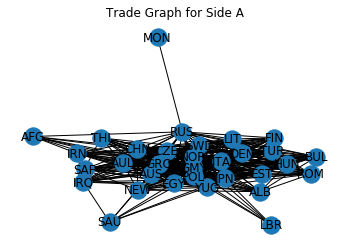

NameError: name 'itertools' is not defined

In [6]:
if __name__ == '__main__':
    trade_data = csv.DictReader(open('data/cow/Dyadic_COW_4.0_shortened.csv', 'r'))
    trade_data = list(trade_data)
    dispute_data = csv.DictReader(open('data/mid/MIDB_5.0.csv', 'r'))

    #TODO: make this interactive
    print("Parsing conflict number.")
    instigatorsA, instigatorsB, sideA, sideB, start_year = parse_conflict_num(dispute_data, 12)

    print("Retrieving trade partners")
    #used to draw the trade relationships between instigators
    instigatorsA_trade_partners, instigatorsB_trade_partners = get_conflict_trade_partners(
            trade_data,
            instigatorsA, 
            instigatorsB, 
            start_year
    )
    #TODO: add utility to intersect two lists so both sides can be shown in the same graph
    #TODO: is there a better way of doing this?
    print("Parsing trade data for side A")
    trade_valuesA = parse_trade_data(trade_data, instigatorsA_trade_partners, start_year) if len(instigatorsA_trade_partners) > 1 else None
    print("Parsing trade data for side B")
    trade_valuesB = parse_trade_data(trade_data, instigatorsB_trade_partners, start_year) if len(instigatorsB_trade_partners) > 1 else None
    draw_trade_war_graphs(instigatorsA, sideA, trade_valuesA, 'A') 
    draw_trade_war_graphs(instigatorsB, sideB, trade_valuesB, 'B') 